In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from math import log2
%matplotlib inline

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.pipeline import make_pipeline
import time
import matplotlib as mpl


from sklearn.preprocessing import StandardScaler,PowerTransformer,MinMaxScaler,QuantileTransformer,normalize
from sklearn.feature_selection import VarianceThreshold, SelectKBest

In [2]:
def Red_corr_list(corr_to_class_stripped,k):
    corr_list = corr_to_class_stripped.index
    red_corr_list = []
    for i in corr_list:
        if corr_to_class_stripped[i] <= k:
            red_corr_list.append(i)
    return red_corr_list

In [3]:
def plot_corr_heatmap(df, fmt=".2f", feat_to_ret="rating", ticksfont=12,abs = True):
    plt.rcParams.update({'font.size': 14, 'font.weight': 'bold'})
    # Compute correlations and save in matrix
    if abs:
        corr = np.abs(df.corr()) # We only used absolute values for visualization purposes! ..."hot-cold" view to just sort between 
    else:
        corr = df.corr()

    # Mask the repeated values --> here: upper triangle

    #print(corr)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True # mask upper triangle

    corr_to_feat = corr.loc[:,feat_to_ret]
    
    f, ax = plt.subplots(figsize=(18, 16))
    sns.heatmap(corr, annot=True, fmt=fmt , mask=mask, vmin=0, vmax=1, linewidths=.5,cmap="YlGnBu")
    plt.tick_params(labelsize=ticksfont)
    return corr_to_feat

In [4]:
def PlotHist(df,xax,labx,laby,tit,savetit,bins='auto'):
    mpl.style.use('seaborn')
    plt.rcParams.update({'font.size': 14})
    fig = plt.figure(figsize=(6,5))

    plt.hist(df[xax],bins = bins)
    plt.title(tit, fontsize=14, weight="bold")
    plt.xlabel(labx, fontsize=14, weight="bold")
    plt.ylabel(laby, fontsize=14, weight="bold")
    plt.savefig(savetit) 

# load the files

In [5]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')
users

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [6]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols)
ratings

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [7]:
m_cols = ['movie_id','movie_title','release_date','video_release_date','IMDb_URL','unknown',\
          'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',\
          'Fantasy','Film_Noir','Horror','Musical','Mystery','Romance','Sci_Fi','Thriller','War','Western']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols,
                     encoding='latin-1')
movies

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
movie_ratings = pd.merge(movies, ratings)
df_all = pd.merge(movie_ratings, users)
df_all

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,...,Thriller,War,Western,user_id,rating,timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,1,0,0,308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,0,0,0,0,0,...,0,0,0,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),0,0,0,0,1,...,0,0,0,308,5,887736696,60,M,retired,95076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,748,"Saint, The (1997)",14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Saint%2C%20Th...,0,1,0,0,0,...,1,0,0,729,4,893286638,19,M,student,56567
99996,751,Tomorrow Never Dies (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-12...,0,1,0,0,0,...,1,0,0,729,3,893286338,19,M,student,56567
99997,879,"Peacemaker, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Peacemaker%2C...,0,1,0,0,0,...,1,1,0,729,3,893286299,19,M,student,56567
99998,894,Home Alone 3 (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,1,...,0,0,0,729,1,893286511,19,M,student,56567


In [9]:
df_all['video_release_date'].isnull()

0        True
1        True
2        True
3        True
4        True
         ... 
99995    True
99996    True
99997    True
99998    True
99999    True
Name: video_release_date, Length: 100000, dtype: bool

In [10]:
df_all.video_release_date.unique()

array([nan])

In [11]:
df_all.occupation.unique()

array(['retired', 'salesman', 'engineer', 'librarian', 'student', 'other',
       'executive', 'administrator', 'artist', 'entertainment',
       'educator', 'scientist', 'none', 'programmer', 'homemaker',
       'marketing', 'technician', 'lawyer', 'writer', 'healthcare',
       'doctor'], dtype=object)

# form teh df_red

In [14]:
df_red = df_all.drop(["movie_id","movie_title","release_date","video_release_date","IMDb_URL","user_id","timestamp","zip_code"], axis= 1)
df_red

,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci_Fi,Thriller,War,Western,rating,age,sex,occupation
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,4,60,M,retired
1,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,5,60,M,retired
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,4,60,M,retired
3,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,4,60,M,retired
4,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,5,60,M,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,4,19,M,student
99996,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,3,19,M,student
99997,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,3,19,M,student
99998,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,19,M,student


In [15]:
df_features = df_red.loc[:,"unknown":"occupation"]
df_features

,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci_Fi,Thriller,War,Western,rating,age,sex,occupation
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,4,60,M,retired
1,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,5,60,M,retired
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,4,60,M,retired
3,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,4,60,M,retired
4,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,5,60,M,retired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,4,19,M,student
99996,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,3,19,M,student
99997,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,3,19,M,student
99998,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,19,M,student


In [16]:
cols = df_red.columns.tolist()
cols

['unknown',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film_Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci_Fi',
 'Thriller',
 'War',
 'Western',
 'rating',
 'age',
 'sex',
 'occupation']

In [17]:
cols = ['rating',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film_Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci_Fi',
 'Thriller',
 'War',
 'Western',
 'unknown',
 'age',
 'sex',
 'occupation']
df_features = df_features[cols]

In [18]:
df_red = df_features
df_red.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   rating       100000 non-null  int64 
 1   Action       100000 non-null  int64 
 2   Adventure    100000 non-null  int64 
 3   Animation    100000 non-null  int64 
 4   Children     100000 non-null  int64 
 5   Comedy       100000 non-null  int64 
 6   Crime        100000 non-null  int64 
 7   Documentary  100000 non-null  int64 
 8   Drama        100000 non-null  int64 
 9   Fantasy      100000 non-null  int64 
 10  Film_Noir    100000 non-null  int64 
 11  Horror       100000 non-null  int64 
 12  Musical      100000 non-null  int64 
 13  Mystery      100000 non-null  int64 
 14  Romance      100000 non-null  int64 
 15  Sci_Fi       100000 non-null  int64 
 16  Thriller     100000 non-null  int64 
 17  War          100000 non-null  int64 
 18  Western      100000 non-null  int64 
 19  unk

In [19]:
df_red.head()

,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci_Fi,Thriller,War,Western,unknown,age,sex,occupation
0,4,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,60,M,retired
1,5,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,60,M,retired
2,4,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,60,M,retired
3,4,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,60,M,retired
4,5,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,60,M,retired


# Different distributions
1) age 

2) sex

3) features

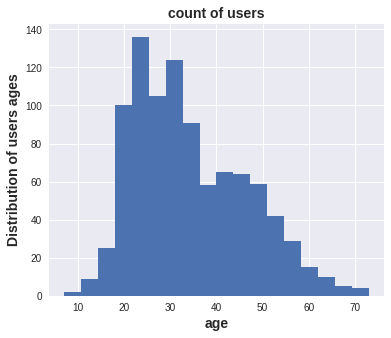

In [20]:
PlotHist(users,"age","age","Distribution of users ages","count of users","Bilder/age_dist.png")

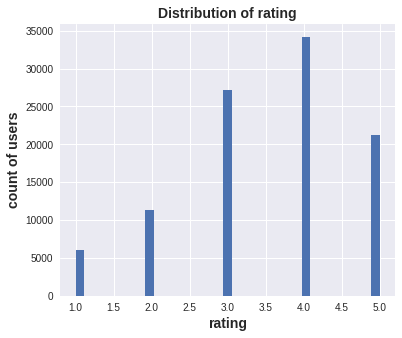

In [21]:
PlotHist(ratings,"rating","rating","count of users","Distribution of rating","Bilder/rating_dist.png",bins = 35)

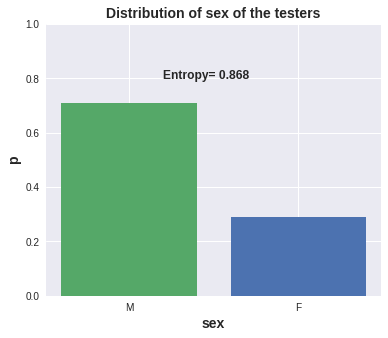

In [22]:
num_samples, num_features = users.shape
count_classes = users["sex"].value_counts()
dist_classes = count_classes.apply(lambda x: x/num_samples)
# Colors
sns_cols = sns.color_palette()
snsblue, snsgreen = sns_cols[0], sns_cols[1]

plt.rcParams.update({'font.size': 12})
mpl.style.use('seaborn')
fig = plt.figure(figsize=(6,5))
plt.bar(dist_classes.index, dist_classes, color=[snsgreen, snsblue])
plt.title("Distribution of sex of the testers", fontsize=14, weight="bold")
plt.ylim((0,1))
plt.ylabel("p", fontsize=14, weight="bold")
plt.xlabel("sex", fontsize=14, weight="bold")

entropy = -sum([p*log2(p) for p in dist_classes])
plt.annotate(f"Entropy= {entropy:.3f}", (0.2, 0.8), fontweight="bold")

plt.savefig("Bilder/sex_dist.png")

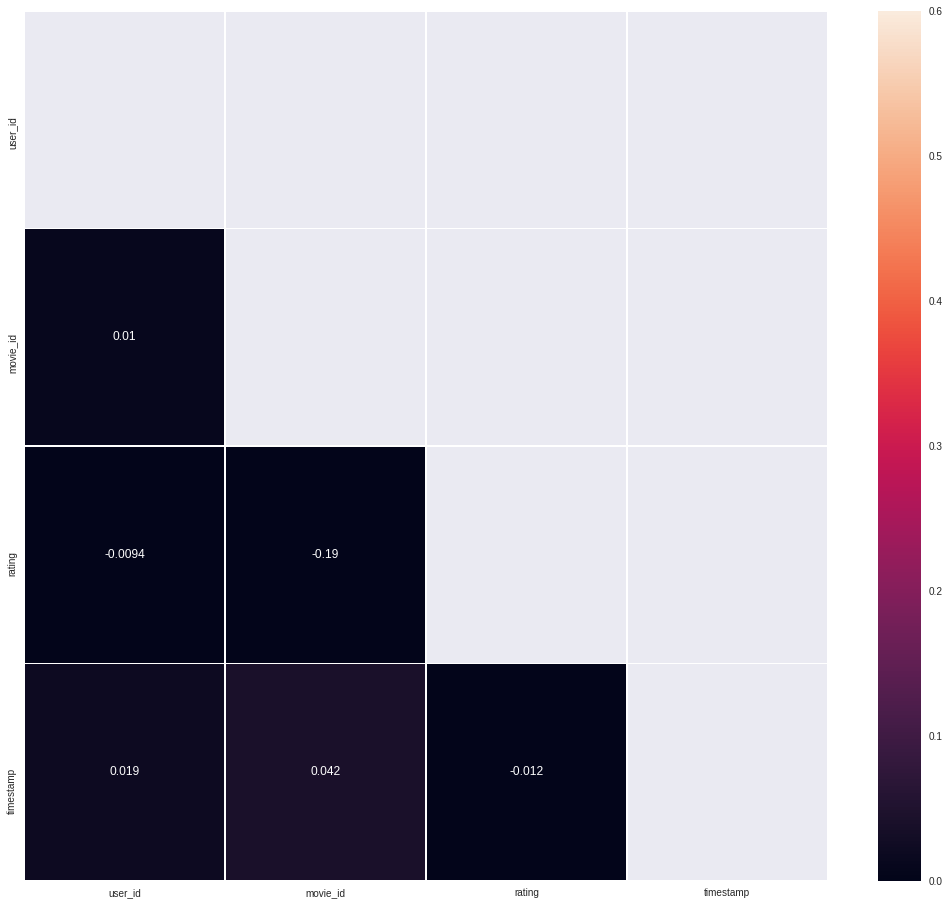

In [23]:
corr = ratings.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # mask upper triangle
f, ax = plt.subplots(figsize=(18, 16))
plt.rcParams.update({'font.size': 12})
sns.heatmap(corr, annot=True, vmin=0, mask=mask, vmax=0.6, linewidths=.5)
plt.savefig("Bilder/heat.png")

In [ ]:
#sns.pairplot("rating","Drama",data = df_red)
sns.regplot(x="rating", y="Drama", data=df_red)

In [ ]:
scaler = StandardScaler()  
scaler.fit(df_red_try) 
df_test_SC = pd.DataFrame(scaler.transform(df_red_try))

In [ ]:
df_red_try = df_red.drop(["sex","occupation"],axis = 1)

In [ ]:
corr_to_class_stripped = plot_corr_heatmap(df_red, ticksfont=16,abs = False)
corr_to_class_stripped

In [ ]:
red_corr_list = Red_corr_list(corr_to_class_stripped,0.3)
red_corr_list = ['rating','Action','Adventure','Animation','Children','Fantasy','Sci_Fi']
df_red_heat = df_red[red_corr_list]

In [ ]:
plt.rcParams.update({'font.size': 12})
si = 5

fig = plt.figure(figsize=(si,si-1))
plt.hist(users['age'])
plt.title("Distribution of users ages", fontsize=14, weight="bold")
plt.ylabel('count of users', fontsize=14, weight="bold")
plt.xlabel('age', fontsize=14, weight="bold")
plt.savefig("Bilder/age_dist.png")

In [ ]:
movie_ratings = pd.merge(movies, ratings)
df_all = pd.merge(movie_ratings, users)
df_all.movie_title

In [ ]:
fig = plt.figure(figsize=(6,5))
plt.hist(ratings['rating'],bins=50)
plt.title("Distribution of rating", fontsize=14, weight="bold")
plt.ylabel('count of users', fontsize=14, weight="bold")
plt.xlabel('rating', fontsize=14, weight="bold")
plt.savefig("Bilder/rating_dist.png")

In [ ]:
corr = df_red_heat.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # mask upper triangle
f, ax = plt.subplots(figsize=(18, 16))
plt.rcParams.update({'font.size': 12})
sns.heatmap(corr, annot=True, vmin=0, mask=mask, vmax=0.6, linewidths=.5)
plt.savefig("Bilder/heat.png")